In [1]:
import pandas as pd
import zipfile
import numpy as np
import io
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image
from torchvision import models
from pytorch_grad_cam import GradCAM
from skimage.feature import peak_local_max
import json

In [2]:
# Process eye tracking data to get the 
def process_eye_tracking_data_classes(csv_path):
    et_data = pd.read_csv(csv_path)
    grouped_data = et_data.groupby(['image_file', 'class'])['response']
    image_classes = {}
    for (img_, target_class), _ in grouped_data:
        image_classes[target_class+'_'+img_+'.jpg'] = target_class
    return image_classes

# Load an image from the zip file in memory
def load_image_from_zip(ZIP_PATH, IMG_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zr:
        with zr.open(IMG_PATH) as file:
            img_data = file.read()
            image = Image.open(io.BytesIO(img_data))
    return image

# Convert an image to rgb
def convert_image_to_rgb(image):
    rgb_img = np.float32(image) / 255
    return rgb_img

# Create the image input tensor
def create_input_tensor(rgb_image):
    input_tensor = preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return input_tensor

# function for creating masks
def create_mask(output, category_idx):
    # Generating the mask
    normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
    mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
    mask_uint8 = 255 * np.uint8(mask == category_idx)
    mask_float = np.float32(mask == category_idx)
    return mask, mask_uint8, mask_float

# Function for performing gradcam
def compute_gradcam(model, target_layers, targets, input_tensor, rgb_image):
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0,:]
        cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
        new_image = Image.fromarray(cam_image)
        return grayscale_cam, cam_image, new_image
    
# Function for getting peak local max
def find_max_points(img_array):
    coordinates = peak_local_max(img_array, min_distance=10, threshold_abs=0.7)
    sorted_coordinates = sorted(coordinates, key=lambda x: img_array[x[0], x[1]], reverse=True)
    top_5_peaks = sorted_coordinates[:5]
    top_5_peaks = [arr.tolist() for arr in top_5_peaks]
    return top_5_peaks

In [3]:
# Segmentation Wrapper
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)["out"]
    
# Semantic Segmentation Target
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


In [4]:
def main(ZIP_PATH):


    # Converter
    PASCAL_CLASSES = [
        '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]

    # Convert class to idx
    pascal_class_to_idx = {cls:idx for (idx,cls) in enumerate(PASCAL_CLASSES)}

    # Dictionary for storing the results
    results = {}

    # Go through each file in the zip file
    with zipfile.ZipFile(ZIP_PATH, 'r') as zr:
        # Showing filepaths and an example file path
        zip_file_paths = [path for path in zr.namelist() if path.lower().endswith('.jpg') and path.startswith('POETdataset/PascalImages/')]

        print(f"Number of file paths: {len(zip_file_paths)}")
        print(f"Example of zip file path: {zip_file_paths[0]}")

        # Go through all files in zipfile
        for idx, file_path in enumerate(zip_file_paths):
            if idx % 200 == 0:
                print(f"Processing image {idx + 1} of {len(zip_file_paths)}")
            # Creating the model and setting to eval model
            model = models.segmentation.fcn_resnet50(pretrained=True, progress=True)
            model.eval()

            # Extract filename and class name
            filename = file_path.split("/")[-1]
            #print(filename)
            class_name = filename.split("_")[0]
            #print(class_name)

            # Load and convert image
            image = load_image_from_zip(ZIP_PATH=ZIP_PATH, IMG_PATH=file_path)
            rgb_image = convert_image_to_rgb(image=image)

            # Setup input tensor
            input_tensor = create_input_tensor(rgb_image=rgb_image)

            # Setting input tensor to cuda if possible
            if torch.cuda.is_available():
                model = model.cuda()
                input_tensor = input_tensor.cuda()
            
            # Creating output
            output = model(input_tensor)

            # Using segmentation wrapper
            model = SegmentationModelOutputWrapper(model=model)
            output = model(input_tensor)

            # Retrieving class name idx
            category_idx = pascal_class_to_idx[class_name]
            # print(f"Class name: {class_name}")
            # print(f"Class name idx: {category_idx}")

            # Generating the mask
            mask, mask_uint8, mask_float = create_mask(output=output, category_idx=category_idx)

            # Target layers and targets
            target_layers = [model.model.backbone.layer4]
            targets = [SemanticSegmentationTarget(category_idx, mask_float)]
            
            # Computing cam
            grayscale_cam, cam_image, new_image = compute_gradcam(
                model=model,
                target_layers=target_layers,
                targets=targets,
                input_tensor=input_tensor,
                rgb_image = rgb_image
            )

            # Create points from image
            points = np.flip(find_max_points(grayscale_cam))
            # print(len(points))

            results[filename] = {
                # 'heatmap': grayscale_cam.tolist(),
                'points': points.tolist()
            }

    return results


In [5]:
ZIP_PATH = '../POETdataset.zip'
results = main(ZIP_PATH=ZIP_PATH)

Number of file paths: 6270
Example of zip file path: POETdataset/PascalImages/sofa_2009_000995.jpg
Processing image 1 of 6270


c:\Users\magnu\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\magnu\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing image 201 of 6270
Processing image 401 of 6270
Processing image 601 of 6270
Processing image 801 of 6270
Processing image 1001 of 6270
Processing image 1201 of 6270
Processing image 1401 of 6270
Processing image 1601 of 6270
Processing image 1801 of 6270
Processing image 2001 of 6270
Processing image 2201 of 6270
Processing image 2401 of 6270
Processing image 2601 of 6270
Processing image 2801 of 6270
Processing image 3001 of 6270
Processing image 3201 of 6270
Processing image 3401 of 6270
Processing image 3601 of 6270
Processing image 3801 of 6270
Processing image 4001 of 6270
Processing image 4201 of 6270
Processing image 4401 of 6270
Processing image 4601 of 6270
Processing image 4801 of 6270
Processing image 5001 of 6270
Processing image 5201 of 6270
Processing image 5401 of 6270
Processing image 5601 of 6270
Processing image 5801 of 6270
Processing image 6001 of 6270
Processing image 6201 of 6270


In [6]:
results_df = pd.DataFrame(results).transpose()
results_df.to_csv('fcn_resnet_results_points.csv', index_label='filename')
print("Dataframe saved successfully")

Dataframe saved successfully


In [7]:
file_path = "fcn_resnet_results_points.json"
with open(file_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

In [8]:
results_df

,points
sofa_2009_000995.jpg,"[[146, 376], [170, 345], [99, 345], [186, 313]..."
sofa_2008_008649.jpg,"[[337, 322], [376, 275], [353, 291], [376, 306..."
sofa_2009_002408.jpg,"[[107, 107], [329, 131], [242, 52], [289, 123]..."
sofa_2011_002291.jpg,"[[194, 139], [344, 171], [321, 172], [305, 171..."
sofa_2008_005395.jpg,"[[123, 242], [170, 250], [186, 258], [154, 250..."
...,...
bicycle_2008_004363.jpg,"[[265, 314], [138, 243], [122, 266], [162, 299..."
bicycle_2009_000805.jpg,"[[321, 235], [321, 211], [321, 251], [305, 211..."
bicycle_2010_005860.jpg,"[[479, 184]]"
cat_2010_002789.jpg,"[[210, 216], [107, 161], [147, 223], [123, 169..."


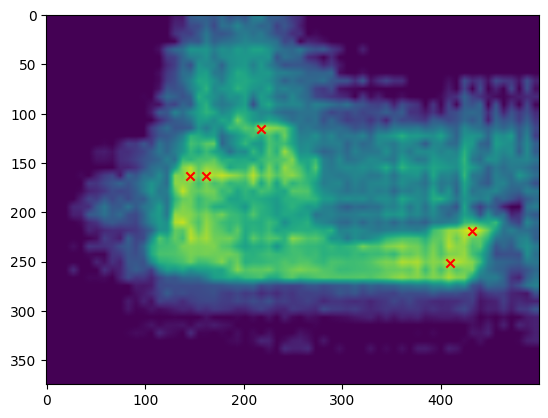

In [175]:
heatmap_test = results_df.iloc[0]
heatmap = heatmap_test['heatmap']
points = heatmap_test['points']
plt.imshow(heatmap)
for point in points:
    plt.scatter(point[0], point[1], marker='x', c='r')

# GradCAM for a Single Image

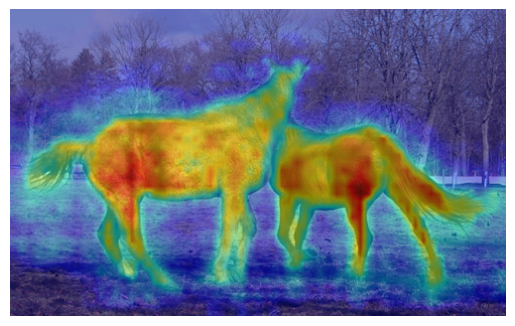

In [5]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# from torchvision import models
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# # Convert image to RGB
# def convert_image_to_rgb(image):
#     return np.float32(image) / 255

# # Create the input tensor
# def create_input_tensor(rgb_image):
#     return preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# # Create segmentation mask
# def create_mask(output, category_idx):
#     normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
#     mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
#     mask_uint8 = 255 * np.uint8(mask == category_idx)
#     mask_float = np.float32(mask == category_idx)
#     return mask, mask_uint8, mask_float

# # Compute Grad-CAM
# def compute_gradcam(model, target_layers, targets, input_tensor, rgb_image):
#     with GradCAM(model=model, target_layers=target_layers) as cam:
#         grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
#         cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
#         return cam_image

# # Wrapper for semantic segmentation model
# class SegmentationModelOutputWrapper(torch.nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#     def forward(self, x):
#         return self.model(x)["out"]

# # Semantic segmentation target
# class SemanticSegmentationTarget:
#     def __init__(self, category, mask):
#         self.category = category
#         self.mask = torch.from_numpy(mask)
#         if torch.cuda.is_available():
#             self.mask = self.mask.cuda()

#     def __call__(self, model_output):
#         return (model_output[self.category, :, :] * self.mask).sum()

# # Function to show the Grad-CAM heatmap
# def show_cam(image_path, class_name):
#     # Define Pascal VOC class names
#     PASCAL_CLASSES = [
#         '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
#         'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
#         'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
#     ]
#     pascal_class_to_idx = {cls: idx for idx, cls in enumerate(PASCAL_CLASSES)}

#     # Load and preprocess the image
#     image = Image.open(image_path).convert("RGB")
#     rgb_image = convert_image_to_rgb(image)
#     input_tensor = create_input_tensor(rgb_image)

#     # Initialize the model
#     model = models.segmentation.fcn_resnet50(pretrained=True, progress=True)
#     model.eval()

#     if torch.cuda.is_available():
#         model = model.cuda()
#         input_tensor = input_tensor.cuda()

#     # Wrap the model for Grad-CAM compatibility
#     model_wrapper = SegmentationModelOutputWrapper(model)

#     # Generate the segmentation mask for the target class
#     output = model_wrapper(input_tensor)
#     category_idx = pascal_class_to_idx[class_name]
#     mask, _, mask_float = create_mask(output, category_idx)

#     # Define Grad-CAM target layers and target
#     target_layers = [model.backbone.layer4]
#     targets = [SemanticSegmentationTarget(category_idx, mask_float)]

#     # Compute Grad-CAM heatmap
#     cam_image = compute_gradcam(
#         model=model_wrapper,
#         target_layers=target_layers,
#         targets=targets,
#         input_tensor=input_tensor,
#         rgb_image=rgb_image
#     )

#     # Show the result
#     plt.figure(1)
#     plt.imshow(image)
#     plt.axis('Off')

#     plt.figure(2)
#     plt.imshow(cam_image)
#     plt.axis('Off')
#     plt.show()

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Convert an image to RGB
def convert_image_to_rgb(image):
    rgb_img = np.float32(image) / 255
    return rgb_img

# Create the image input tensor
def create_input_tensor(rgb_image):
    input_tensor = preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return input_tensor

# Function for creating masks
def create_mask(output, category_idx):
    normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
    mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
    mask_uint8 = 255 * np.uint8(mask == category_idx)
    mask_float = np.float32(mask == category_idx)
    return mask, mask_uint8, mask_float

# Function for performing Grad-CAM
def compute_gradcam(model, target_layers, targets, input_tensor, rgb_image):
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
        return grayscale_cam, cam_image

# Segmentation Wrapper
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)["out"]
    
# Semantic Segmentation Target
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

# Function to process and visualize a single image
def process_single_image(image_path, class_name):
    # Define Pascal VOC classes
    PASCAL_CLASSES = [
        '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]
    pascal_class_to_idx = {cls: idx for idx, cls in enumerate(PASCAL_CLASSES)}

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    rgb_image = convert_image_to_rgb(image)
    input_tensor = create_input_tensor(rgb_image)

    # Initialize the segmentation model
    model = models.segmentation.fcn_resnet50(pretrained=True, progress=True)
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        input_tensor = input_tensor.cuda()

    # Wrap the model output
    model_wrapper = SegmentationModelOutputWrapper(model)

    # Generate the output for segmentation
    output = model_wrapper(input_tensor)
    category_idx = pascal_class_to_idx[class_name]

    # Create the mask for the target class
    mask, mask_uint8, mask_float = create_mask(output, category_idx)

    # Set up Grad-CAM
    target_layers = [model.backbone.layer4]
    targets = [SemanticSegmentationTarget(category_idx, mask_float)]

    # Compute Grad-CAM
    grayscale_cam, cam_image = compute_gradcam(
        model=model_wrapper,
        target_layers=target_layers,
        targets=targets,
        input_tensor=input_tensor,
        rgb_image=rgb_image
    )

    # Display the Grad-CAM overlay
    plt.figure(1)
    plt.imshow(cam_image)
    plt.axis("off")
    plt.show()

# Example usage
image_path = "../subdataset/subdataset/horse_2011_000840.jpg"  # Replace with your image path
class_name = "horse"  # Replace with the desired class name
process_single_image(image_path, class_name)